In [1]:
from __future__ import division
from __future__ import print_function

import argparse
import time

import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
from torch import optim
import networkx as nx

from gae.model import GCNModelVAE
from gae.optimizer import loss_function
from gae.utils import preprocess_graph, get_roc_score

C:\Users\ZHANGSHANFAN\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', type=str, default='gcn_vae', help="models used")
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--hidden1', type=int, default=32, help='Number of units in hidden layer 1.')
parser.add_argument('--hidden2', type=int, default=16, help='Number of units in hidden layer 2.')
parser.add_argument('--lr', type=float, default=0.01, help='Initial learning rate.')
parser.add_argument('--dropout', type=float, default=0., help='Dropout rate (1 - keep probability).')
parser.add_argument('--dataset-str', type=str, default='wiki', help='type of dataset.')

args,_ = parser.parse_known_args()

In [3]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def mask_test_edges(adj):
    # Function to build test set with 10% positive links
    # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.
    # TODO: Clean up.

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    adj_triu = sp.triu(adj)
    adj_tuple = sparse_to_tuple(adj_triu)
    edges = adj_tuple[0]
    edges_all = sparse_to_tuple(adj)[0]
    num_test = int(np.floor(edges.shape[0] / 10.))
    num_val = int(np.floor(edges.shape[0] / 20.))

    all_edge_idx = list(range(edges.shape[0]))
    np.random.shuffle(all_edge_idx)
    val_edge_idx = all_edge_idx[:num_val]
    test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]
    test_edges = edges[test_edge_idx]
    val_edges = edges[val_edge_idx]
    #train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)
    train_edges = edges

    def ismember(a, b, tol=5):
        rows_close = np.all(np.round(a - b[:, None], tol) == 0, axis=-1)
        return np.any(rows_close)

    test_edges_false = []
    while len(test_edges_false) < len(test_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue
        if ismember([idx_i, idx_j], edges_all):
            continue
        if test_edges_false:
            if ismember([idx_j, idx_i], np.array(test_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(test_edges_false)):
                continue
        test_edges_false.append([idx_i, idx_j])

    val_edges_false = []
    while len(val_edges_false) < len(val_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue
        if ismember([idx_i, idx_j], train_edges):
            continue
        if ismember([idx_j, idx_i], train_edges):
            continue
        if ismember([idx_i, idx_j], val_edges):
            continue
        if ismember([idx_j, idx_i], val_edges):
            continue
        if val_edges_false:
            if ismember([idx_j, idx_i], np.array(val_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(val_edges_false)):
                continue
        val_edges_false.append([idx_i, idx_j])

    #assert ~ismember(test_edges_false, edges_all)
    #assert ~ismember(val_edges_false, edges_all)
    #assert ~ismember(val_edges, train_edges)
    #assert ~ismember(test_edges, train_edges)
    #assert ~ismember(val_edges, test_edges)

    data = np.ones(train_edges.shape[0])

    # Re-build adj matrix
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false

In [4]:
def load_data(adj_name):
    if adj_name == 'Cora':
        nodes_numbers = 2708
        datasets = Planetoid('./datasets', adj_name)
        edges = datasets[0].edge_index
        raw_edges = pd.DataFrame([[edges[0,i].item(), edges[1,i].item()] for i in range(edges.shape[1])])
        
    elif adj_name == 'wiki':
        from torch_geometric.datasets import KarateClub
        nodes_numbers = 34
        datasets = KarateClub()
        edges = datasets[0].edge_index
        raw_edges = pd.DataFrame([[edges[0,i].item(), edges[1,i].item()] for i in range(edges.shape[1])])
        
    elif adj_name == 'Citeseer':
        nodes_numbers = 3327
        datasets = Planetoid('./datasets', adj_name)
        edges = datasets[0].edge_index
        raw_edges = pd.DataFrame([[edges[0,i].item(), edges[1,i].item()] for i in range(edges.shape[1])])
    elif adj_name == 'soc':
        nodes_numbers = 2426
        raw_edges = pd.read_csv("datasets/soc-hamsterster.edges",header=None,sep=' ') - 1
    else:
        print("Dataset is not exist!")
    
    drop_self_loop = raw_edges[raw_edges[0]!=raw_edges[1]]
    
    graph_np = np.zeros((nodes_numbers, nodes_numbers))
    
    for i in range(drop_self_loop.shape[0]):
        graph_np[drop_self_loop.iloc[i,0], drop_self_loop.iloc[i,1]]=1
        graph_np[drop_self_loop.iloc[i,1], drop_self_loop.iloc[i,0]]=1
    
    adj = nx.adjacency_matrix(nx.from_numpy_matrix(graph_np))
    
    features = torch.eye(nodes_numbers)
    
    return adj, features

In [5]:
def gae_for(args):
    print("Using {} dataset".format(args.dataset_str))
    adj, features = load_data(args.dataset_str)
    
    n_nodes, feat_dim = features.shape

    # Store original adjacency matrix (without diagonal entries) for later
    adj_orig = adj
    adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
    adj_orig.eliminate_zeros()

    adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
    adj = adj_train

    # Some preprocessing
    adj_norm = preprocess_graph(adj)
    adj_label = adj_train + sp.eye(adj_train.shape[0])
    # adj_label = sparse_to_tuple(adj_label)
    adj_label = torch.FloatTensor(adj_label.toarray())

    pos_weight = torch.tensor(float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum())
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

    model = GCNModelVAE(feat_dim, args.hidden1, args.hidden2, args.dropout)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    hidden_emb = None
    for epoch in range(args.epochs):
        t = time.time()
        model.train()
        optimizer.zero_grad()
        recovered, mu, logvar = model(features, adj_norm)
        
        loss = loss_function(preds=recovered, labels=adj_label,
                             mu=mu, logvar=logvar, n_nodes=n_nodes,
                             norm=norm, pos_weight=pos_weight)
        loss.backward()
        cur_loss = loss.item()
        optimizer.step()

        hidden_emb = mu.data.numpy()
        roc_curr, ap_curr = get_roc_score(hidden_emb, adj_orig, val_edges, val_edges_false)

        print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(cur_loss),
              "val_ap=", "{:.5f}".format(ap_curr),
              "time=", "{:.5f}".format(time.time() - t)
              )

    print("Optimization Finished!")

    roc_score, ap_score = get_roc_score(hidden_emb, adj_orig, test_edges, test_edges_false)
    print('Test ROC score: ' + str(roc_score))
    print('Test AP score: ' + str(ap_score))
    return recovered, hidden_emb

In [6]:
if __name__ == '__main__':
    R, H = gae_for(args)

Using wiki dataset
Epoch: 0001 train_loss= 1.64608 val_ap= 0.91667 time= 0.01190
Epoch: 0002 train_loss= 1.77904 val_ap= 0.91667 time= 0.00370
Epoch: 0003 train_loss= 1.84975 val_ap= 0.91667 time= 0.00826
Epoch: 0004 train_loss= 1.70799 val_ap= 1.00000 time= 0.00100
Epoch: 0005 train_loss= 1.76430 val_ap= 1.00000 time= 0.00000
Epoch: 0006 train_loss= 1.63367 val_ap= 1.00000 time= 0.00801
Epoch: 0007 train_loss= 1.46413 val_ap= 1.00000 time= 0.00693
Epoch: 0008 train_loss= 1.53990 val_ap= 1.00000 time= 0.00670
Epoch: 0009 train_loss= 1.34412 val_ap= 1.00000 time= 0.00581
Epoch: 0010 train_loss= 1.46007 val_ap= 1.00000 time= 0.00100
Epoch: 0011 train_loss= 1.33880 val_ap= 1.00000 time= 0.00482
Epoch: 0012 train_loss= 1.23419 val_ap= 1.00000 time= 0.00000
Epoch: 0013 train_loss= 1.15020 val_ap= 1.00000 time= 0.00811
Epoch: 0014 train_loss= 1.33935 val_ap= 1.00000 time= 0.00321
Epoch: 0015 train_loss= 1.21349 val_ap= 1.00000 time= 0.00000
Epoch: 0016 train_loss= 1.09521 val_ap= 1.00000 tim

Epoch: 0175 train_loss= 0.75210 val_ap= 0.91667 time= 0.01117
Epoch: 0176 train_loss= 0.73841 val_ap= 0.91667 time= 0.00100
Epoch: 0177 train_loss= 0.77777 val_ap= 0.91667 time= 0.00511
Epoch: 0178 train_loss= 0.77337 val_ap= 0.91667 time= 0.00600
Epoch: 0179 train_loss= 0.74427 val_ap= 0.91667 time= 0.00000
Epoch: 0180 train_loss= 0.75575 val_ap= 0.91667 time= 0.00768
Epoch: 0181 train_loss= 0.77973 val_ap= 0.91667 time= 0.00000
Epoch: 0182 train_loss= 0.73357 val_ap= 0.91667 time= 0.00000
Epoch: 0183 train_loss= 0.79524 val_ap= 0.91667 time= 0.00921
Epoch: 0184 train_loss= 0.75007 val_ap= 0.91667 time= 0.00000
Epoch: 0185 train_loss= 0.73447 val_ap= 0.91667 time= 0.00751
Epoch: 0186 train_loss= 0.74892 val_ap= 0.91667 time= 0.00104
Epoch: 0187 train_loss= 0.74555 val_ap= 0.91667 time= 0.00000
Epoch: 0188 train_loss= 0.77080 val_ap= 0.91667 time= 0.00815
Epoch: 0189 train_loss= 0.75152 val_ap= 0.91667 time= 0.00104
Epoch: 0190 train_loss= 0.74830 val_ap= 0.91667 time= 0.00000
Epoch: 0

In [11]:
R

tensor([[ 6.2154,  4.7007,  1.7558,  ..., -1.5199, -4.6195, -3.5207],
        [ 4.7007, 12.9761,  4.7801,  ...,  0.8146, -1.8520, -2.4588],
        [ 1.7558,  4.7801,  4.4128,  ...,  1.1005,  0.6651,  1.5305],
        ...,
        [-1.5199,  0.8146,  1.1005,  ...,  3.7963,  3.0875,  1.3946],
        [-4.6195, -1.8520,  0.6651,  ...,  3.0875,  8.1052,  6.1496],
        [-3.5207, -2.4588,  1.5305,  ...,  1.3946,  6.1496,  6.7396]],
       grad_fn=<MmBackward0>)

In [13]:
H

array([[ 1.30461827e-01, -2.88779080e-01,  1.20158382e-02,
        -6.27354085e-02, -1.00097072e+00, -1.46700814e-02,
        -5.91346845e-02,  3.57969813e-02, -9.79984552e-02,
        -1.36513102e+00,  1.04825921e-01, -7.37837970e-01,
        -4.34701949e-01,  1.75610259e-01,  5.11421114e-02,
         1.34598762e-01],
       [ 1.06962073e+00, -5.04231215e-01, -1.54418588e-01,
        -1.74446672e-01, -1.15610051e+00,  2.72515386e-01,
        -4.84245181e-01, -1.80380762e-01,  1.19848005e-01,
        -8.78116012e-01,  2.98546255e-01, -1.04035199e+00,
        -1.94671661e-01,  4.63818014e-01, -9.76114124e-02,
         5.90064609e-03],
       [ 1.17872930e+00, -4.89560574e-01, -2.37653881e-01,
        -7.73195624e-02, -7.54566193e-01,  4.08942133e-01,
        -4.65353966e-01, -2.12982327e-01,  3.29619348e-01,
        -9.98944044e-03,  3.49092841e-01, -7.58342683e-01,
         1.50664151e-01,  4.31818664e-01, -1.25557929e-01,
        -2.67666820e-02],
       [ 8.29577506e-01, -4.34308887e

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [16]:
adj_rec = np.dot(H, H.T)

In [17]:
adj_rec

array([[ 3.7805464 ,  3.6174307 ,  1.6441196 , ..., -1.2723212 ,
        -2.994737  , -2.8782425 ],
       [ 3.6174307 ,  5.349978  ,  3.9298851 , ..., -0.8675732 ,
        -0.60095114, -0.03976725],
       [ 1.6441196 ,  3.9298851 ,  3.7213962 , ...,  0.0156409 ,
         1.6726137 ,  2.3062534 ],
       ...,
       [-1.2723212 , -0.8675732 ,  0.0156409 , ...,  1.0075049 ,
         1.516843  ,  1.6332638 ],
       [-2.994737  , -0.60095114,  1.6726137 , ...,  1.516843  ,
         5.7484837 ,  6.2215223 ],
       [-2.8782425 , -0.03976725,  2.3062534 , ...,  1.6332638 ,
         6.2215223 ,  6.816687  ]], dtype=float32)

In [19]:
adj_rec = sigmoid(adj_rec)

In [21]:
nodes_number = 34
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
data = dataset[0]
edges = data.edge_index
start_nodes = np.array(edges[0])
end_nodes = np.array(edges[1])

graph_np = np.zeros((34, 34))

for i in range(edges.shape[1]):
    graph_np[start_nodes[i], end_nodes[i]]=1

In [22]:
adj_rec

array([[0.9776985 , 0.9738506 , 0.8380947 , ..., 0.21886013, 0.04766421,
        0.05323965],
       [0.9738506 , 0.9952742 , 0.9807326 , ..., 0.2957595 , 0.3541261 ,
        0.49005955],
       [0.8380947 , 0.9807326 , 0.9763716 , ..., 0.5039101 , 0.84192395,
        0.90939367],
       ...,
       [0.21886013, 0.2957595 , 0.5039101 , ..., 0.73253155, 0.82007307,
        0.8366162 ],
       [0.04766421, 0.3541261 , 0.84192395, ..., 0.82007307, 0.9968225 ,
        0.99801767],
       [0.05323965, 0.49005955, 0.90939367, ..., 0.8366162 , 0.99801767,
        0.9989059 ]], dtype=float32)

In [23]:
true_edges = graph_np.reshape(nodes_number*nodes_number)

In [25]:
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
for gama in [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]:
    print("gama : ",gama)
    nodes_s = copy.deepcopy(adj_rec)
    for i in range(nodes_s.shape[0]):
        nodes_s[i,i]=0
    nodes_s[nodes_s>gama] = 1
    nodes_s[nodes_s<=gama] = 0
    pred_edges = nodes_s.reshape(nodes_number*nodes_number)
    print("edges： ",pred_edges.sum())
    print("ACC SCORE： ",accuracy_score(true_edges, pred_edges))
    print("AP： ",precision_score(true_edges, pred_edges, average='macro'))
    print("RECALL： ",recall_score(true_edges, pred_edges, average='macro'))
    print("F1 SCORE： ",f1_score(true_edges, pred_edges, average='macro'))

gama :  0.2
edges：  914.0
ACC SCORE：  0.34429065743944637
AP：  0.5853391684901532
RECALL：  0.621
F1 SCORE：  0.34064141345734195
gama :  0.25
edges：  858.0
ACC SCORE：  0.3892733564013841
AP：  0.5863878850456031
RECALL：  0.6415897435897436
F1 SCORE：  0.37991691055576327
gama :  0.3
edges：  752.0
ACC SCORE：  0.4809688581314879
AP：  0.5999183694965241
RECALL：  0.6945897435897437
F1 SCORE：  0.4559283105538612
gama :  0.35
edges：  688.0
ACC SCORE：  0.5363321799307958
AP：  0.6097818525144106
RECALL：  0.7265897435897436
F1 SCORE：  0.499903147074396
gama :  0.4
edges：  632.0
ACC SCORE：  0.5847750865051903
AP：  0.6199270460914098
RECALL：  0.7545897435897436
F1 SCORE：  0.5379511571205884
gama :  0.45
edges：  608.0
ACC SCORE：  0.6055363321799307
AP：  0.624819919323857
RECALL：  0.7665897435897436
F1 SCORE：  0.5542838589228458
gama :  0.5
edges：  558.0
ACC SCORE：  0.6487889273356401
AP：  0.6363205907385431
RECALL：  0.7915897435897437
F1 SCORE：  0.5886524822695035
gama :  0.55
edges：  532.0
ACC SCORE

In [26]:
gama = 0.80
s = copy.deepcopy(adj_rec)
for i in range(s.shape[0]):
    s[i,i]=0
s[s>gama] = 1
s[s<=gama] = 0

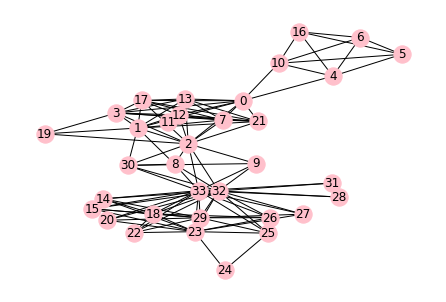

In [27]:
import networkx as nx
G_predict=nx.from_numpy_array(s)
true_pos=nx.kamada_kawai_layout(G_predict)
nx.draw(G_predict,true_pos,with_labels = True,node_color = 'pink',node_size = 300, width=1)

In [35]:
pd.DataFrame(s).to_csv("karate_graph.txt", header=None, columns=None)

In [31]:
!pip3 install openyxl

ERROR: Could not find a version that satisfies the requirement openyxl (from versions: none)
ERROR: No matching distribution found for openyxl


In [34]:
s

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.]], dtype=float32)